<h3> Implizit and explicit Euler with Dirichlet Boundaries </h3>

The implicit Euler method in matrix form can be written as

\begin{equation}
    (M+kA)u_h^{n+1} = (Mu_h^n+kF^{n+1}) \tag{1}
\end{equation}

and the explicit Euler method in matrix form can be written as

\begin{equation}
    Mu_h^{n+1} = (M-kA)u_h^n+kF^{n} \tag{2}
\end{equation}

where $M$ denotes the mass matrix, $A$ the stiffness matrix and $k$ the step-size. 

For mesh nodes that are not equidistantly distributed, the basis functions of $S^1$ and their weak gradients are given by
\begin{equation*}
    \zeta_j(x) = \begin{cases}
\frac{x-x_{j-1}}{x_j-x_{j-1}}& \text{ for } x\in [x_{j-1}, x_j]\\
\frac{x_{j+1}-x}{x_{j+1}-x_{j}}& \text{ for } x\in [x_{j}, x_{j+1}]
\end{cases}
\end{equation*}
and
\begin{equation*}
\nabla\zeta_i(x) = \begin{cases}
\frac{1}{x_j-x_{j-1}}& \text{ for } x\in [x_{j-1}, x_j)\\
\frac{-1}{x_{j+1}-x_{j}}& \text{ for } x\in (x_{j}, x_{j+1}]
\end{cases}
\end{equation*}
for $i \in \{1,.., N-1\}$. 

We can now calculate the mass matrix $M$ and the stiffness matrix $A$ as 

\begin{equation*}
    (M)_{ij} = \begin{cases} 
        \frac{x_{\max\{i,j\}}-x_{\min\{i,j\}}}{6} & \text{ if } |i-j|=1 \\
        \frac{x_{j+1}-x_{j-1}}{3} & \text{ if } |i-j|=0 \\
        0 & \text{ else } 
    \end{cases}
\end{equation*}
and 
\begin{equation*}
    (A)_{ij} = \begin{cases} 
        \frac{-1}{x_{\max\{i,j\}}-x_{\min\{i,j\}}} & \text{ if } |i-j|=1 \\
        \frac{1}{x_{j}-x_{j-1}} + \frac{1}{x_{j+1}-x_{j}}& \text{ if } |i-j|=0 \\
        0 & \text{ else.}
    \end{cases}
\end{equation*}

For the right hand side we can use nodal interpolation, meaning $f_j(t) = f(x_j, t)$ and get
\begin{equation*}
    F_i(t) = \int \zeta_i \sum_j f_j(t) \zeta_j = f_{i-1}(t) \frac{x_{i}-x_{i-1}}{6}+ f_i(t) \frac{x_{j+1}-x_{j-1}}{3} +f_{i+1}(t) \frac{x_{i+1}-x_i}{6}.
\end{equation*}

Because of the Dirichlet boundaries, the dimensions of $A$, $M$  an $F$ are smaller than the lenght of $x$. 

In [ ]:
import numpy as np 
import scipy

def buildAMF(x):
    N = len(x)
    M = np.zeros((N-2, N-2))
    A = np.zeros((N-2, N-2))
    F = np.zeros((N-2, 3))

    for i in range(N-2):
        if i-1 >= 0:
            M[i,i-1] = (x[i+1]-x[i])/6
            A[i,i-1] = -1/(x[i+1]-x[i])
        if i+1 < N-2:
            M[i,i+1] = (x[i+2]-x[i+1])/6
            A[i,i+1] = -1/(x[i+2]-x[i+1])
            
        M[i,i] = (x[i+2]-x[i])/3
        A[i,i] = 1/(x[i+2]-x[i+1])+1/(x[i+1]-x[i])

        F[i, 0] = (x[i+1]-x[i])/6
        F[i, 1] = (x[i+2]-x[i])/3
        F[i, 2] = (x[i+2]-x[i+1])/6
    return [A, M, F]


def decompose(M):
    L = scipy.linalg.cholesky(M, lower=True)
    return [L, L.T]


def heat(x,k,K,u0,f,explicit=False):

    A, M, F = buildAMF(x)
    if explicit:
        L, LT = decompose(M)
    else:
        L, LT = decompose((M+k*A))

    sol = np.zeros((len(u0), K+1))
    sol[:, 0] = np.array(u0)
        
    for j in range(0, K):
        if explicit:
            t = j*k
        else:
            t = (j+1)*k

        Ft = np.array([f(x[i], t)*F[i,0]+f(x[i+1],t)*F[i,1]+f(x[i+2],t)*F[i,2] for i in range(0,len(x)-2)])
        
        if explicit:
            b = (M-k*A).dot(sol[:,j])+k*Ft  
        else:
            b = M.dot(sol[:,j])+k*Ft  
        
        # vorwaertssubstitution
        y = scipy.linalg.solve_triangular(L,b, check_finite=False, lower=True)
        # rueckwaertssubstitution
        sol[:,j+1] = scipy.linalg.solve_triangular(LT, y, check_finite=False)

    return sol

<h3> Zeta-Bubble Function  </h3>

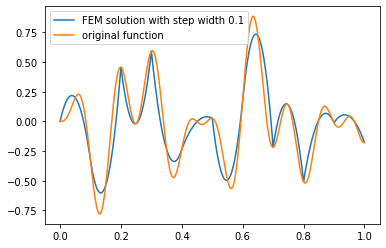

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

H = 10
h = 1./H
x = np.arange(0,1,1./10000)
FUNCTION = 3

def f(x):
    x = np.array(x)
    if FUNCTION == 0:
        ret_val = np.ones(x.size)
    elif FUNCTION == 1:
        ret_val = np.sin(13*x)+np.cos(33*x)
    elif FUNCTION == 2:
        ret_val = x*x 
    elif FUNCTION == 3:
        ret_val = np.sin(37*x)*np.sin(13*x)*np.sin(7*x)
    elif FUNCTION == 4:
        tmp = int(np.floor(x.size/10))
        ret_val = np.zeros(x.size)
        ret_val[tmp:x.size] = np.exp(-1./np.array(x[tmp:x.size]))
    else:
        ret_val = x
    return ret_val

k = np.floor(x*H)
n1 = k*h
n2 = (k+1)*h
m = (k+1/2)*h

zeta1 = -x*H+k+1
zeta2 = x*H-k
bubble = 4*zeta1*zeta2

Ih_f = f(n1)*zeta1+f(n2)*zeta2+bubble*(f(m)-1/2*(f(n1)+f(n2)))
plt.plot(x, Ih_f, label="FEM solution with step width {}".format(h))
plt.plot(x, f(x), label="original function")
plt.legend()
plt.show()

